# Building Shor’s Algorithm from Scratch: Factoring 15 

## Notebook Overview ⚛️

> This notebook walks you through one of the most fascinating applications of quantum computing — **Shor’s algorithm** — built entirely from scratch using only basic quantum gates in Qiskit, without relying on any pre-built libraries or high-level abstractions.


In this notebook, we manually construct the quantum portion of **Shor’s algorithm** to factor the integer $15$. Shor’s algorithm efficiently factors large integers by reducing the problem to **period finding**, which is solved using the **quantum phase estimation** (QPE) subroutine.

We assume `gcd(a, N) = 1`, so that modular inverse operations and periodicity are well-defined. The quantum routine estimates the period $r$ of the function $f(x) = a^x \mod N$, which is then used classically to compute the factors of $N$. 

This notebook focuses only on the **quantum circuit construction** and skips the classical post-processing steps like computing the continued fraction or checking factor conditions. The implementation draws on techniques from the [Qiskit community tutorial](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/shor_algorithm.ipynb) and the works of [Draper](https://arxiv.org/abs/quant-ph/0008033v1) and [Beauregard](https://arxiv.org/abs/quant-ph/0205095).



## Shor's Algorithm overview 👀
**Inputs:** A composite number $N$.

**Outputs:** A non-trival factor of $N$. 

**Procedure:**

1.  If $N$ is even, return the factor 2.
2.  Deteremine whether $N = a^{b}$ for integers $a\geq 1$ and $b\geq 2$, if so return the factor $a$.
3.  Randomly choose $a$ in the range $1$ to $N-1$. if $\text{gcd}(a,N)\geq 1$ then return the factor $\text{gcd}(a,N)$.
4.  Use the order-finding subroutine to find the order $r$ of 
    $$
    f(a) = x^{a} \text{mod} \ N
    $$
5.  If $r$ is even and $x^{r/2} \neq -1(\text{mod}\ N)$  then compute $\text{gcd}(x^{r/2}\pm 1,N)$ and test to see if one of these is a non-trival factor, returning that factor if so. Otherwise, the algorithm fails and back to step 1.

## From Factorization to Period Finding ⚗️
From [Qiskit community tutorial](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/shor_algorithm.ipynb), the number thoery that underlines Shor's algorithm relates to periodic modulo sequences. Let's have a look at an example of such a sequence. Let's consider the sequence of the power of two:

$$
1,\ 2,\ 4,\ 8,\ 16,\ 32,\ 64,\ 128,\ 256,\ 512,\ 1024,\ \dots
$$

Now compute each value modulo 15:

$$
1,\ 2,\ 4,\ 8,\ 1,\ 2,\ 4,\ 8,\ 1,\ 2,\ 4,\ \dots
$$


and we can easily see that sequence repeats every four numbers, and this is the periodic modulo sequence with a period of **$4$**.

The reduction of factorization of $N$ to the problem of finding the period of an integer $x$ less than $N$ and greater than $1$ depends on the following result from number theory:

> The function $\mathcal{F}(a) = x^{a} (\text{mod}\ N)$ is periodic function, where $x$ is an integer coprime to $N$ and $a \geq 0$.

Note that two numers are coprime, if the only positive integer that divides both of them is 1, for example, $\text{gcd}(2,9) = 1$ and $\text{gcd}(8,15) = 1$, for an examples. On the other hand, $\text{gcd}(2,8) = 2$, so $2$ and $8$ are not coprime.

> Since $\mathcal{F}(a)$ is a periodic function, it has some period $r$. Knowing that $x^{0} \text{mod} \ N =1$, this means that $x^{r} \text{mod} \ N =1$ since the function is periodic, and thus $r$ is just the first non-zero power where $x^{r} = 1 \ \text{mod}$ (the result that we are looking for in the [order finding](./order_finding.md) problem).

Based on some basic algebras:

$$
\begin{array}{c}
x^{r} \equiv 1\ \text{mod}\\
x^{r} = (x^{r/2})^{2} \equiv 1\ \text{mod}\\
(x^{r/2})^{2} - 1 \equiv 0\ \text{mod}\\
(x^{r/2} + 1)(x^{r/2} - 1) \equiv 0\ \text{mod}
\end{array}
$$

The product $(x^{r/2} + 1)(x^{r/2} - 1) \equiv 0\ \text{mod}$ is an integer multiple of $N$, the number to be factored. Thus, as long as $(x^{r/2} + 1)$ of $(x^{r/2} - 1)$ is not a multiple of $N$, then at least one of $(x^{r/2} + 1)$ or $(x^{r/2} - 1)$ must have a nontrivial factor in common with $N$.

Therefore, we can also know that calculate both $\text{gcd}(x^{r/2} \pm 1,N)$ will obtain a factor of $N$, which can be accomlished by using Euclidean algorithm.

Please find [Qiskit community tutorial](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/shor_algorithm.ipynb) for more details!



## A Very Simple Example! Trust Me! ✍️

Just in case you're already a bit lost, let’s walk through a super simple example to build intuition.

Consider the sequence of powers of 2:

$$
1,\ 2,\ 4,\ 8,\ 16,\ 32,\ 64,\ 128,\ 256,\ 512,\ 1024,\ \dots
$$

Now compute each value modulo 15:

$$
1,\ 2,\ 4,\ 8,\ 1,\ 2,\ 4,\ 8,\ 1,\ 2,\ 4,\ \dots
$$

Clearly, the sequence **repeats every 4 steps**. This is the key idea behind Shor’s algorithm: finding the period $r$ of the function:

$$
\mathcal{F}(a) = x^a \bmod N
$$

Let’s pick $x = 2$, so we’re computing:

$$
\mathcal{F}(a) = 2^a \bmod 15
$$

From the sequence above, we see:

$$
2^4 \bmod 15 = 16 \bmod 15 = 1
$$

Thus, the **period** is $r = 4$.

### Finding Factors

Now that we’ve found a non-trivial period $r = 4$, we compute:

$$
\gcd(2^{r/2} \pm 1,\ 15) = \gcd(2^2 \pm 1,\ 15) = \gcd(5,15)\ \text{and}\ \gcd(3,15)
$$

That gives us:

- $\gcd(5,15) = 5$
- $\gcd(3,15) = 3$

Boom! We’ve factored 15 as $3 \times 5$!

A piece of cake 🍰, right? Hold tight — we will talk about Quantum Phase Estumation (QPE) then begin constructing the actual quantum circuit.

## Quantum Phase Estimation (QPE)

> 📌 Extracted from *M. A. Nielsen and I. L. Chuang, *Quantum Computation and Quantum Information*, 10th Anniversary Ed., Cambridge: Cambridge University Press, 2010.*

<div style="text-align: center;">
    <img src="../../images/QPE_overview.png" alt="QPE_overview" style="width: 838px; height: 309px;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        Schematic of the overall phase estimation procedure.
    </p>
</div>

The Quantum Fourier transformation is the key to a general procedure know as *phase estimation*, which in turn is the key for many quantum algorithms. Suppose a unitary operator $U$ has an eigenvector $|u\rangle$ with eigenvalue $e^{2\pi i\phi}$,  where the value of $\phi$ is unknown. The goal of the phase estimation is to estimate $\phi$. To perform the estimation we assume that we have available *black boxes (oracles)* capable of preparing the state $|u\rangle$ and performing the controlled-$U^{2^{j}}$ operation, for sutible non-negative integers $j$.

The quantum phase estimation procedure uses two registers. The first register contains $t$ qubits initially in the state $|0\rangle$. How we choose $t$ depends on two things:

1.  The number of digits of accuracy we wish to have in our estimate for $\phi$.
2.  With what probability we wish the phase estimation precedure to be successful. 

The second register begins in the state $|u\rangle$, and contains as many qubits as is necessary to store $|u\rangle$.

Phase estimation is performed in two stages. 

1.  First, the circuit begins by applying a Hadamard transform to the first register, followed by application of controlled-$U$ operations on the second register, with $U$ raised to successive powers of two. The final state of the first registers can be seen as:

$$
\frac{1}{2^{t/2}}(|0\rangle + e^{2\pi i (2^{t}-1)\phi}|1\rangle)(|0\rangle + e^{2\pi i (2^{t}-2)\phi}|1\rangle)...(|0\rangle + e^{2\pi i (2^{0})\phi}|1\rangle) = \frac{1}{2^{t/2}}\sum_{k=0}^{2^{t}-1}e^{2\pi i \phi k}|k\rangle
$$

We omit the second register from this description, since it stays in the state $|u\rangle$ throughout the computation.

<div style="text-align: center;">
    <img src="../../images/Phase_estimate.jpg" alt="Phase_estimate" style="width: 800px; height: 400px;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        The frist stage of the phase estiamtion procedure. Normalization factors of $1/\sqrt{2}$ have been omitted on the right.
    </p>
</div>

2.  The second stage of the phase estimation is to apply the *inverse* quantum Fourier transform on the first register. This is obtained by reversing the circuit for the quantum Fourier transform in the previous section, and can be done in $\Theta(t^{2})$ steps. The third and final stage of phase estimation is to read out the state of the first register by doing a measurement in the computational basis. An overall schematic of the algorithm is shown below:

To sharpen our intuition as to why phase estimation works, suppose $\phi$ may be expressed exactly in $t$ bits, as $\phi = 0.\phi{1}...\phi{t}$. Then the state 

$$
\frac{1}{2^{t/2}}(|0\rangle + e^{2\pi i (2^{t}-1)\phi}|1\rangle)(|0\rangle + e^{2\pi i (2^{t}-2)\phi}|1\rangle)...(|0\rangle + e^{2\pi i (2^{0})\phi}|1\rangle) = \frac{1}{2^{t/2}}\sum_{k=0}^{2^{t}-1}e^{2\pi i \phi k}|k\rangle
$$

resulting from the first state of phase estimation may be written 

$$
\frac{1}{2^{t/2}}(|0\rangle + e^{2\pi i0.\phi_{t}}|1\rangle)(|0\rangle + e^{2\pi i0.\phi_{t-1}\phi_{t}}|1\rangle)...(|0\rangle + e^{2\pi i 0.\phi_{1}\phi_{2}...\phi_{t}}|1\rangle).
$$

The second stage of phase estimation is to apply the inverse quantum Fourier transform. By comparing the previous equation with the product form the Fourier transform, 

$$
|j_{1},...,j_{n}\rangle \rightarrow \frac{(|0\rangle + e^{2\pi i0.j_{n}}|1\rangle)(|0\rangle + e^{2\pi i0.j_{n-1}j_{n}}|1\rangle)(|0\rangle + e^{2\pi i0.j_{1}j_{2}\cdots j_{n}}|1\rangle)}{2^{n/2}}.
$$

we see that the output state from the second stage is the product state $|\phi_{1}...\phi_{t}\rangle$. 
$$
\frac{1}{2^{t/2}}(|0\rangle + e^{2\pi i0.\phi_{t}}|1\rangle)(|0\rangle + e^{2\pi i0.\phi_{t-1}\phi_{t}}|1\rangle)...(|0\rangle + e^{2\pi i 0.\phi_{1}\phi_{2}...\phi_{t}}|1\rangle) \text{QFT}^{\dagger}\rightarrow |\phi_{1}...\phi_{t}\rangle
$$

A measurement in the computational basis therefore gives us $\phi$ exactly!

## References

1. **Thomas G. Draper** (2000). *Addition on a Quantum Computer*. [arXiv:quant-ph/0008033v1](https://arxiv.org/abs/quant-ph/0008033v1)  
   Introduces the quantum addition circuit based on the Quantum Fourier Transform.

2. **Stéphane Beauregard** (2003). *Circuit for Shor’s Algorithm Using 2n+3 Qubits*. [arXiv:quant-ph/0205095](https://arxiv.org/abs/quant-ph/0205095)  
   Optimized Shor's algorithm circuit using fewer qubits.

3. M. A. Nielsen and I. L. Chuang, *Quantum Computation and Quantum Information*, 10th Anniversary Ed., Cambridge: Cambridge University Press, 2010.

4. **Qiskit Community**. *Shor's Algorithm for Integer Factorization – Tutorial Notebook*.  
   [GitHub: qiskit-community-tutorials](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/shor_algorithm.ipynb)

5. **Qiskit Implementation of Shor’s Algorithm**.  
   [Source: qiskit/algorithms/factorizers/shor.py](https://github.com/Qiskit/qiskit/blob/stable/0.17/qiskit/algorithms/factorizers/shor.py#L99)

6. **Qiskit Quantum Fourier Transform (QFT)** – Circuit library documentation.  
   [API Reference](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.QFT)

7. **Qiskit Controlled Phase Gate (CPhaseGate)** – Used in QFT and QADD routines.  
   [API Reference](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.CPhaseGate)

8. **Qiskit Internal QFT Decomposition Code** – Shows how QFT is built from basic gates.  
   [Source code](https://github.com/Qiskit/qiskit/blob/stable/2.0/qiskit/synthesis/qft/qft_decompose_full.py#L22-L80)

9. **Ckassiq - Shor's Algorithm** - [Shor's Algorithm](https://github.com/Classiq/classiq-library/blob/main/algorithms/algebraic/shor/shor.ipynb)


## Qubit Ordering (READ ME!)

Qubits used in this notebook are ordered as $|q_{n-1}, \dots, q_0\rangle$, where `q_0` is the least significant bit (LSB) and `q_{n-1}` is the most significant bit (MSB), following Qiskit's convention.  
For example, the integer 6 is encoded as $|110\rangle$, with MSB `q_2` on the left and LSB as `q_0` on the right.

## Quantum Arithmetic Circuit Blocks

This notebook implements quantum arithmetic gates based on the methods from [Draper (2000)](https://arxiv.org/abs/quant-ph/0008033v1) and [Beauregard (2003)](https://arxiv.org/abs/quant-ph/0205095).

### Included Components

1. **`QFTBlock`** – Quantum Fourier Transform (QFT) circuit.  
2. **`QADDERBlock`** – Quantum adder for adding classical constants to quantum registers using phase rotations.  
3. **`add_mod_N_classic`** – Modular addition circuit computing $(a + b) \bmod N$, where $a$ is classical.  
4. **`CMULTaMODN_c`** – Controlled modular multiplier gate for classical constant $a$.  
5. **`Controlled_U_a`** – Controlled modular exponentiation circuit computing $a^x \bmod N$.




In [1]:
# import some important packages.
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import StatevectorSampler as Sampler

## Quantum Fourier Transform (QFT)

A powerful strategy in mathematics and computer science is to *transform* a problem into a different domain where it becomes easier to solve. One such transformation is the **discrete Fourier transform (DFT)**.

In standard notation, the DFT maps a vector $x_0, x_1, \ldots, x_{N-1}$ of complex amplitudes to another vector $y_0, y_1, \ldots, y_{N-1}$, defined as:

$$
y_k = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} x_j e^{2\pi i jk / N}.
$$

The **quantum Fourier transform (QFT)** applies this same transformation within a quantum circuit. In the quantum context, we work over the orthonormal computational basis states $|0\rangle, |1\rangle, \ldots, |N-1\rangle$, and the QFT is defined as a *linear operator* acting on these basis states:

$$
|j\rangle \rightarrow \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} e^{2\pi i jk / N} |k\rangle.
$$

On an arbitrary quantum state $\sum_{j=0}^{N-1} x_j |j\rangle$, the QFT maps the amplitudes $x_j$ to their discrete Fourier transform $y_k$, yielding:

$$
\sum_{j=0}^{N-1} x_j |j\rangle \rightarrow \sum_{k=0}^{N-1} y_k |k\rangle.
$$

Though this definition involves complex exponentials, the QFT is a [unitary transformation](../Quantum_Algorithm_101/hilbert_space.md#unitary-operators), which ensures it can be implemented on a quantum computer using a sequence of quantum gates.

<div style="text-align: center;">
    <img src="../../images/QFT_circuit.jpg" alt="QFT_circuit" style="width: 900px; height: 270px;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        Efficient circuit for the quantum Fourier transform. Not shown are swap gates at the end of the circuit which reverse the order of the qubitsm or normalization factors of $1/\sqrt{2}$ in the output.
    </p>
</div>

For a deeper dive into the mathematical structure and circuit-level implementation, see: [Understanding the Quantum Fourier Transform](https://pcchoucr97.github.io/Understanding-Cryptography/quantum_computation/fourier_transformation/#phase-estimation).


### Building QFT gate 

In [2]:
class QFTBlock:
    def __init__(self, b):
        #  Initialize the QFT block with the number of qubits
        self.b = b

    def build(self):
        qr = QuantumRegister(self.b, "x")
        qc = QuantumCircuit(qr, name="QFT")
        for i in reversed(range(self.b)):
            qc.h(i)           
            for j in reversed(range(i)):
                qc.cp(np.pi / 2**(i-j), qr[j], qr[i])
                
        return qc.to_gate(label="QFT")

    def build_inverse(self):
        qr = QuantumRegister(self.b, "x")
        qc = QuantumCircuit(qr, name="QFT_dg")
        for i in (range(self.b)):
            for j in (range(i)):
                qc.cp(- np.pi / 2**(i-j), qr[j], qr[i])
            qc.h(i)
        return qc.to_gate(label="QFT_dg")

### Testing Our QFT Gate

To verify our `QFTBlock` and its inverse, we prepare a 4-qubit input state representing the binary number $b = 5$, i.e., $|0101\rangle$. 

Following Qiskit's convention, the qubit ordering is:  

$$
|b_3\, b_2\, b_1\, b_0\rangle = |qr[3],\, qr[2],\, qr[1],\, qr[0]\rangle
$$

We apply the `QFTBlock` followed by its inverse (`QFTBlock.inverse()`). If implemented correctly, the circuit should return the system to the original state $|0101\rangle$.


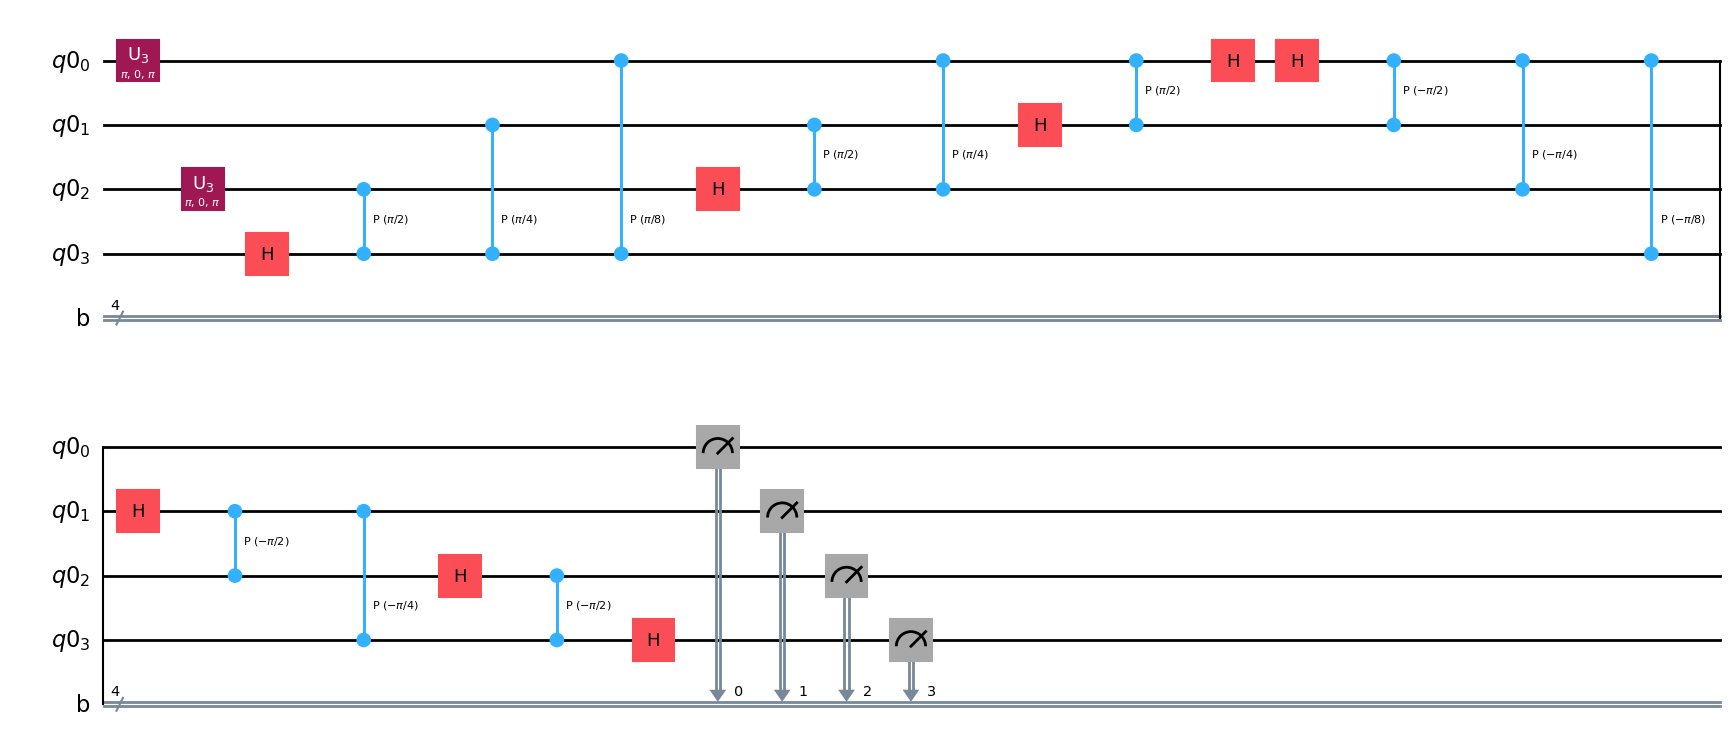

In [3]:
## Test our QFT gate

# 1. Setup parameters
n = 4 # bit length for b
idx = 0

# 2. Initialize circuit layout
qr = QuantumRegister(n)
cr = ClassicalRegister(n,'b')
qc = QuantumCircuit(qr, cr)

# 3. Initialize b = 5 -> |0101> = |b_4b_3b_2b_1> = |qr[3],qr[2],qr[1],qr[0]>
qc.x(0)
qc.x(2)

# 4. Create QFT and IQFT opreations
qft_gate = QFTBlock(n)
qc.append(qft_gate.build(), [qr[i] for i in range(n)]) # QFT
qc.append(qft_gate.build_inverse(), [qr[i] for i in range(n)])  # iQFT

# 5. Measure register b
qc.measure(range(n), range(n))

# 5. Draw our circuit
qc.decompose().draw('mpl', justify='none')

In [4]:
# Run our circuit via quantum simulator and print our result!
# get_counts() will map our result using a big-endian method, that is, LSB will be displayed at rightmost side of |psi>

# 1. Setup quantum sampler
sampler = Sampler()
job1 = sampler.run([qc],shots=4096)
result = job1.result()

# 2. Get sampling result
print(result[0])
print(result[0].data)
print(result[0].data._data.keys())

bit_array = result[0].data['b']
counts = bit_array.get_counts()

# We should get |0101> since |b> - QFT - IQFT -> |b> since QFT is a unitary transformation.
print(counts)

SamplerPubResult(data=DataBin(b=BitArray(<shape=(), num_shots=4096, num_bits=4>)), metadata={'shots': 4096, 'circuit_metadata': {}})
DataBin(b=BitArray(<shape=(), num_shots=4096, num_bits=4>))
dict_keys(['b'])
{'0101': 4096}


Well done! 🎉  
You’ve just verified that $|0101\rangle$ is indeed the binary representation of 5 — and more importantly, you’ve successfully implemented the **Quantum Fourier Transform (QFT)** and its inverse from scratch using only basic quantum gates!

Now that we can move in and out of the Fourier basis, we’re ready for the next essential building block of modular exponentiation: the **quantum adder gate**, `φADD(a)`.

This gate allows us to add a classical number directly to a quantum register in the QFT basis — efficiently and without the need for extra quantum registers.

Let’s dive into how it works and how to implement it step by step!

---


## Quantum Adder Gate (`φADD(a)`) – Based on Beauregard's Construction

In Shor’s algorithm, we don't need to add two full quantum registers. Instead, we only need to add a known classical value $a$ to a quantum register $|b\rangle$, as the goal is to compute $a^x \mod N$, where $a$ is a fixed classical number.

As described in [Beauregard (2003)](https://arxiv.org/abs/quant-ph/0205095), this can be done efficiently in the **Fourier space**, using the `φADD(a)` gate. This circuit applies a set of single-qubit **phase shift gates**, where the angles are determined by the classical bits of $a$. Since $a$ is known in advance, all gate parameters can be precomputed, and no additional quantum register is needed for $a$. This minimizes both qubit count and circuit depth.

To prevent overflow in modular arithmetic, we extend the quantum register holding $b$ from $n$ to $n+1$ qubits. The quantum state $|b\rangle$ is first transformed using QFT, and the least significant qubit is ensured to be $|0\rangle$ before addition. This ensures that $\phi(b)$ behaves like the QFT of a proper $(n+1)$-bit integer.

Beauregard introduces **visual conventions** in the circuit diagrams:
- A **thick black bar on the right** marks the inverse of the `φADD(a)` gate.
- A **thick bar on the left** denotes the standard forward `φADD(a)` gate.
- The **unitary inverse** $φADD(-a)$ is used for subtraction and comparison circuits.

These design decisions help save qubits and simplify implementation, especially for modular adders and controlled arithmetic gates required in Shor’s algorithm.

<div style="text-align: center;">
    <img src="../../images/Qadder.png" alt="Qadder" style="width: 800px; height: 619px;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        The quantum addition as described by Draper.
    </p>
</div>

<div style="text-align: center;">
    <img src="../../images/Qadder_2.png" alt="Qadder_2" style="width: 1059px; height: 207px;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        The circuit for addition of a classical value a to the quantum value b in the Fourier space.
    </p>
</div>

In [5]:
class QADDERBlock:
    def __init__(self, n,m):
        self.n = n
        self.m = m

    def build(self,qr_b, qr_a):
        # check range(m) = range(n)
        qc = QuantumCircuit(qr_b,qr_a, name="Q_ADDER")
        full_q = list(qr_b) + list(qr_a) # now full_q is a list of qubits
        
        for i in reversed(range(len(qr_b),len(full_q))):
            for j in reversed(range(len(qr_b),i+1)):
                if j == i - self.n:
                    continue  # skip when control == target
                k = i - j + 1
                qc.cp(2 * np.pi / 2**(k), full_q[j], full_q[i - self.n])

        return qc.to_gate(label="Q_ADDER")

    def build_inverse_manually(self,qr_b, qr_a):
        return None

    def build_inverse(self,qr_b, qr_a):
        # check range(m) = range(n)
        qc = QuantumCircuit(qr_b,qr_a, name="Q_ADDER_dag")
        full_q = list(qr_b) + list(qr_a) # now full_q is a list of qubits

        for i in (range(len(qr_b),len(full_q))):
            for j in (range(len(qr_b),i+1)):
                if j == i - self.n:
                    continue  # skip when control == target
                k = i - j + 1
                qc.cp(- 2 * np.pi / 2**(k), full_q[j], full_q[i - self.n])
        return qc.to_gate(label="Q_ADDER_dag")

        

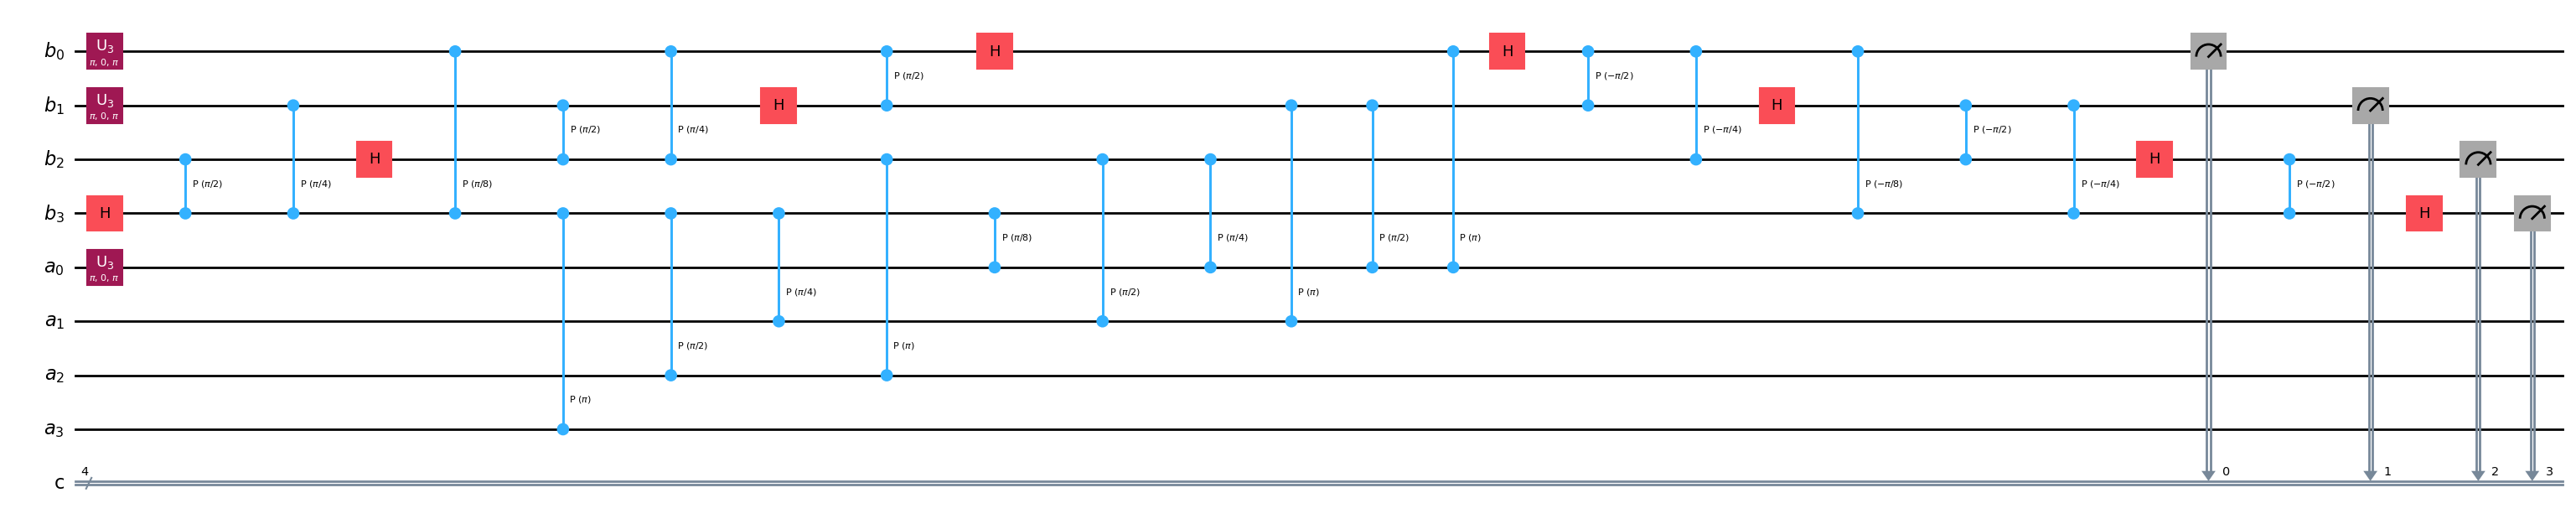

In [6]:
# --- Simple Test Case for QADDERBlock ---

# 1. Setup parameters
n = 4
m = 4

# 2. Create the circuit
qr_b = QuantumRegister(n, "b")
qr_a = QuantumRegister(m, "a")
cr = ClassicalRegister(n, "c")
qc = QuantumCircuit(qr_b, qr_a, cr)

# 3. Initialize b 
qc.x(0)  # |0011⟩ = 3 on b |q[3], q[2], q[1], q[0]>
qc.x(1)  

# 4. Initialize a 
qc.x(4)  # |0001⟩ = 1 on a |q[7], q[6], q[5], q[4]>

# 5. Construct QADDER operations
QADDER = QADDERBlock(n, m)
QFT = QFTBlock(n)
qc.append(QFT.build(), qr_b[:])                          
qc.append(QADDER.build(qr_b, qr_a), qr_b[:] + qr_a[:])  
qc.append(QFT.build_inverse(), qr_b[:])

# 6. Measure register b
qc.measure(qr_b, cr)

# 7. Draw our quantum circuit
qc.decompose().draw('mpl', fold=-1)


In [7]:
# Run our circuit via quantum simulator and print our result!
# get_counts() will map our result using a big-endian method, that is, LSB will be displayed at rightmost side of |psi>

# 1. Setup quantum sampler
sampler = Sampler()
job3 = sampler.run([qc],shots=4096)
result = job3.result()

# 2. Get sampling result
print(result[0])
print(result[0].data)
print(result[0].data._data.keys())

bit_array = result[0].data['c']
counts = bit_array.get_counts()

# We should get |0100> since b + a = |0011> + |0001> = |0100>
print(counts)

SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=4>)), metadata={'shots': 4096, 'circuit_metadata': {}})
DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=4>))
dict_keys(['c'])
{'0100': 4096}


## Adding Classical Number Directly Using Phase Rotation (optimzied way)

In the Fourier basis, adding a classical number $a$ to a quantum register $|b\rangle$ can be performed efficiently without needing a second quantum register. This technique applies a sequence of single-qubit **phase rotations** directly to the qubits of $|b\rangle$ in the QFT basis.

Because $a$ is a known constant, all rotation angles can be precomputed and applied without control logic or ancillae. This eliminates the need for complex carry operations and significantly reduces both qubit count and gate depth.

The following gate, `QAdderClassicalBlock`, implements this technique to achieve more resource-efficient and faster quantum addition.


In [8]:
# This function can help us map our classical input on the predefined circuit by giving classical values, start and stop indices.
def apply_value(qc, value, start, bits):
        for i in range(bits):
            if (value >> i) & 1:
                qc.x(start + i)

In [9]:
class QAdderClassicalBlock:
    """Adds a classical integer to a quantum register using phase rotations."""
    def __init__(self, n):
        self.n = n

    def build(self, a_val):
        """Builds the gate to add the classical value a_val."""
        qc = QuantumCircuit(self.n, name=f"ADD_c({a_val})")
        for k in range(self.n):
            if (a_val >> k) & 1:
                for j in range(k, self.n):
                    angle = np.pi / (2**(j - k))
                    qc.p(angle, j) # phase rotation 
        return qc.to_gate()

    def build_inverse(self, a_val):
        """Builds the inverse gate to subtract the classical value a_val."""
        add_gate = self.build(a_val)
        return add_gate.inverse()

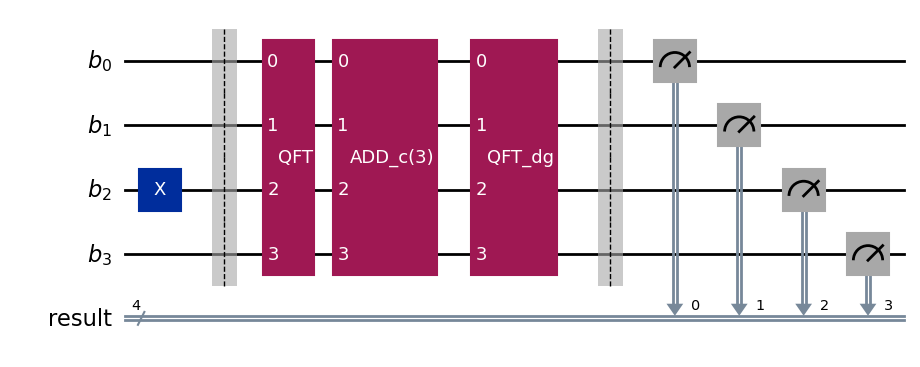

In [10]:
# --- Simple Test Case for QAdderClassicalBlock ---

# 1. Setup parameters
n_bits = 4
b_val = 4   # Initial quantum value: |0010>
a_val = 3   # Classical value to add
expected_val = b_val + a_val

#2. Create the circuit
qr = QuantumRegister(n_bits, name='b')
cr = ClassicalRegister(n_bits, name='result')
qc = QuantumCircuit(qr, cr)

apply_value(qc, b_val, 0, n_bits)
        
qc.barrier()
# 4. Construct the full adder operation: QFT -> Phase Add -> IQFT
qft_gate = QFTBlock(n_bits).build()
adder_gate = QAdderClassicalBlock(n_bits).build(a_val)
iqft_gate = QFTBlock(n_bits).build_inverse()

qc.append(qft_gate, qr)
qc.append(adder_gate, qr)
qc.append(iqft_gate, qr)
qc.barrier()

# 5. Measure the final state
qc.measure(qr, cr)
qc.draw('mpl')

In [11]:
# Run our circuit via quantum simulator and print our result!
# get_counts() will map our result using a big-endian method, that is, LSB will be displayed at rightmost side of |psi>

# 1. Setup quantum sampler 
sampler = Sampler()
job3 = sampler.run([qc],shots=4096)
result = job3.result()

# 2. Get sampling result
print(result[0])
print(result[0].data)
print(result[0].data._data.keys())
bit_array = result[0].data['result']
counts = bit_array.get_counts()

# We should get 0111
print(counts)

# 3. Find and print the most likely outcome
if counts:
    most_likely_binary_rev = max(counts, key=counts.get)
    readable_binary = most_likely_binary_rev
    measured_val = int(readable_binary, 2)
    print(f"\nMost likely measured value: {measured_val} (binary: {readable_binary})")

SamplerPubResult(data=DataBin(result=BitArray(<shape=(), num_shots=4096, num_bits=4>)), metadata={'shots': 4096, 'circuit_metadata': {}})
DataBin(result=BitArray(<shape=(), num_shots=4096, num_bits=4>))
dict_keys(['result'])
{'0111': 4096}

Most likely measured value: 7 (binary: 0111)


Well done again! 🎉  
You’ve successfully added the classical value **3** to the quantum Fourier state $|4\rangle$ by constructing your very own quantum adder gate!

Next, we’ll take things a step further and explore **modular addition** — a key ingredient for building modular arithmetic circuits in Shor’s algorithm.

---

## Modular Addition (`add_mod_N`) Using Phase Rotation-Based QFT Adder

Once we have a working `φADD(a)` gate that adds a classical number $a$ in the Fourier basis, we can extend it to perform **modular addition** — that is, compute $(a + b) \bmod N$ for a classical $a$ and a quantum register $|b\rangle$.

This is non-trivial because we must ensure that if $a + b \geq N$, we subtract $N$ — but do so **reversibly**, without leaking any information or corrupting ancilla qubits.

### Core Construction (Based on Beauregard’s Circuit)

- **Input**: A QFT-encoded quantum register $|b\rangle$ with $b < N$, and a classical constant $a < N$.
- **Step 1**: Apply `φADD(a)` to obtain $φ(a + b)$.
- **Step 2**: Apply inverse `φADD(N)` to compute $φ(a + b - N)$.
- **Step 3**: Introduce an **ancilla qubit** initialized to $|0\rangle$ to determine if subtraction was needed:
  - Apply an inverse QFT to read out the **most significant bit (MSB)**.
  - Use a CNOT to copy the MSB into the ancilla.
  - Apply QFT again to return to the Fourier basis.
- **Step 4**: Conditionally apply `φADD(N)` using the ancilla as control — to **restore** the subtracted $N$ if $a + b < N$.
- **Step 5**: The ancilla now contains garbage; we must **uncompute it**:
  - Use a NOT + CNOT + inverse QFT + inverse `φADD(a)` to bring the ancilla back to $|0\rangle$.
- **Step 6**: Resulting register now holds $φ((a + b) \bmod N)$ and a clean ancilla.

> 🔥 The role of the final `φADD(a)` and ancilla cleanup **is crucial** — it allows qubit reuse and ensures no unintended entanglement or decoherence.

### Optimization Tip

Beauregard's circuit cleverly avoids excess overhead by **only double-controlling the `φADD(a)` gates**, not the full modular addition circuit. This keeps depth and complexity manageable, especially for large $N$.

> 📌 For a visual and code-based explanation of this logic, refer to: [Classiq’s Shor Notebook](https://github.com/Classiq/classiq-library/blob/main/algorithms/algebraic/shor/shor.ipynb)

<div style="text-align: center;">
    <img src="../../images/Double_controlled_phiADDMODN_gate.png" alt="Double_controlled_phiADDMODN_gate" style="width: 1170px; height: 440px;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        The circuit for addition of a classical value a to the quantum value b in the Fourier space.
    </p>
</div>

> 📌 Don't forget initializing `ctrl_1` and `ctrl_2` to $|1\rangle$ otherwise you will just get $|b\rangle$ 😂.

In [12]:
class add_mod_N_classic:
    def __init__(self, n, measure_flag=False):
        self.n = n
        self.measure_flag = measure_flag

    def build(self, a_val, N_val):
        """Builds the gate to add the classical value a_val."""    
        # circuit layout
        # b[0]...b[n-1] | ctrl_aux | x[0]...x[x-1] | ctrl_1 |
        # l + n + m + 3 = number of qubits in the circuit
        # l = number of bits in N, n = number of bits in b, m = number of bits in a
        num_qubits = self.n + 3
        
        qc = QuantumCircuit(num_qubits, name=f" ({a_val}) ADD MOD ({N_val})")
        qr_b = list(qc.qubits[0:self.n])  # b[0] (LSB) to b[n-1] (MSB)
        
        # These are the relative positions within the add_mod_N gate's own circuit
        # They will be mapped to the correct global qubits when appended
        ctrl_aux = qc.qubits[-3]        
        ctrl_2   = qc.qubits[-2]
        ctrl_1   = qc.qubits[-1]
        
        # Controlled phi add
        add_a_qadder = QAdderClassicalBlock(self.n).build(a_val)
        add_a_cc_adder = add_a_qadder.control(2)
        qc.append(add_a_cc_adder, [ctrl_2, ctrl_1] + qr_b)
        
        # Subtract N
        add_N_qadder_dag = QAdderClassicalBlock(self.n).build_inverse(N_val)
        qc.append(add_N_qadder_dag, qr_b[:])
        
        # Inverse QFT
        iqft_gate = QFTBlock(self.n).build_inverse()
        qc.append(iqft_gate, qr_b)
        
        # Controlled flag (copy the last qubit of b to ctrl_aux)
        # This sets vtrl_aux to 1 if qr_b[-1] is 1
        qc.cx(qr_b[-1], ctrl_aux)

        # QFT on b
        qft_gate = QFTBlock(self.n).build()
        qc.append(qft_gate, qr_b)

        # Add N, Controlled aux, target add_N_qadder
        add_N_qadder = QAdderClassicalBlock(self.n).build(N_val)
        add_N_ctrl_qadder = add_N_qadder.control(1)
        qc.append(add_N_ctrl_qadder, [ctrl_aux] + qr_b) # ctrl_aux is the control,
        
        # Controlled subtract a
        sub_a_qadder_dag = QAdderClassicalBlock(self.n).build_inverse(a_val)
        sub_a_cc_adder = sub_a_qadder_dag.control(2)
        qc.append(sub_a_cc_adder, [ctrl_1, ctrl_2] + qr_b )

        # Inverse QFT
        iqft_gate = QFTBlock(self.n).build_inverse()
        qc.append(iqft_gate, qr_b)

        # Controlled flag
        # Swap the last qubit of b with ctrl_aux
        qc.x(qr_b[-1])
        qc.cx(qr_b[-1], ctrl_aux)
        qc.x(qr_b[-1])
        
        # QFT on b
        qft_gate = QFTBlock(self.n).build()
        qc.append(qft_gate, qr_b)

        # Controlled phi add
        add_a_qadder = QAdderClassicalBlock(self.n).build(a_val)
        add_a_cc_adder = add_a_qadder.control(2)
        qc.append(add_a_cc_adder, [ctrl_1, ctrl_2] + qr_b)
        
        return qc.to_gate()
        
    def build_inverse(self, a_val, N_val):
        """Builds the inverse gate to subtract the classical value a_val."""
        mod_add_gate = self.build(a_val, N_val)
        return mod_add_gate.inverse()

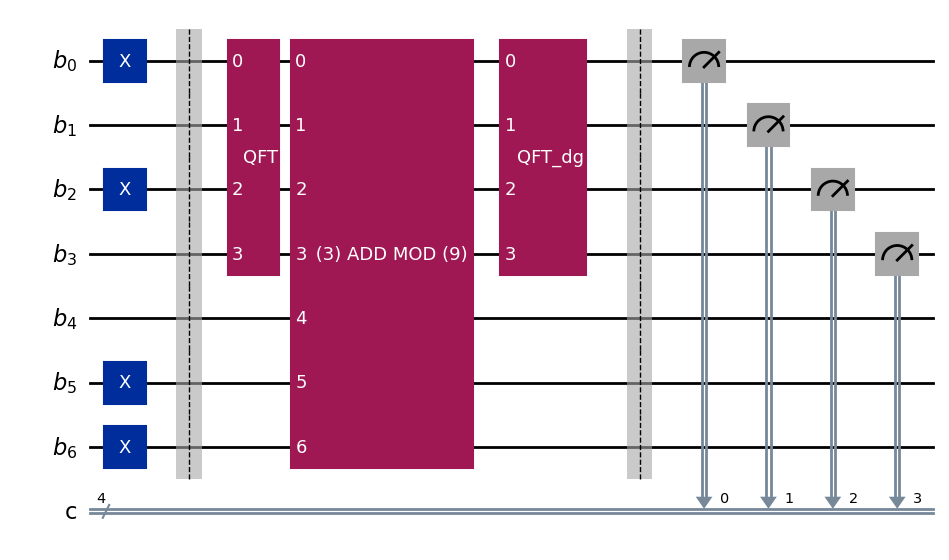

In [13]:
import math
# --- Simple Test Case for QAdderClassicalBlock ---
# a < N and b < N

# 1. Setup parameters
n_bits = 4
b_val = 5   # Initial quantum value: |0010>
a_val = 3   # Classical value to add
N_val = 9 

expected_val =( b_val + a_val ) % N_val # (a + b) MOD N = (3 + 5) MOD 9 = 8

# 2. Create the circuit
qr = QuantumRegister(n_bits + 3, name='b')
cr = ClassicalRegister(n_bits, name='c')
qc = QuantumCircuit(qr, cr)

# 3. Initialize b
for i in range(n_bits):
    if (b_val >> i) & 1:
        qc.x(i)

# 4. init ctrl 1 and 2
qc.x(5)
qc.x(6)

qc.barrier()

# 5. Construct the full adder operation: QFT -> Phase Add -> IQFT
qft_gate = QFTBlock(n_bits).build()
mod_adder_gate = add_mod_N_classic(n_bits).build(a_val, N_val)
iqft_gate = QFTBlock(n_bits).build_inverse()

qc.append(qft_gate, qr[:n_bits]) # need one more bit for overflow
qc.append(mod_adder_gate, qr)
qc.append(iqft_gate, qr[:n_bits])
qc.barrier()

# 6. Measure the final state
qc.measure(qr[:n_bits], cr)

# 7. Draw our circuit
#qc.decompose().draw('mpl')#, justify='none')
qc.draw('mpl')


In [14]:
# 1. Setup quantum sampler 
sampler = Sampler()
job_add_mod_N_classic = sampler.run([qc],shots=4096)
result = job_add_mod_N_classic.result()

# 2. Get sampling result
print(result[0])
print(result[0].data)
print(result[0].data._data.keys())
bit_array = result[0].data['c']
counts = bit_array.get_counts()

# 3. We should get 1000
print(counts)

# Find and print the most likely outcome
if counts:
    #Qiskit returns binary strings in reverse order, so we flip it
    most_likely_binary_rev = max(counts, key=counts.get)
    readable_binary = most_likely_binary_rev
    measured_val = int(readable_binary, 2)
    print(f"\nMost likely measured value: {measured_val} (binary: {readable_binary})")

SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=4>)), metadata={'shots': 4096, 'circuit_metadata': {}})
DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=4>))
dict_keys(['c'])
{'1000': 4096}

Most likely measured value: 8 (binary: 1000)


🎉 Impressive! You’ve completed the modular adder — one of the hardest parts!

## Controlled Modular Multiplier Gate (`CMULTaMODN_c`)

To build the controlled modular multiplication gate needed in Shor’s algorithm, we use the doubly controlled `φADD(a)MOD(N)` gate introduced earlier.

This gate, called `CMULT(a)MOD(N)`, takes three inputs:

$$
|c\rangle|x\rangle|b\rangle
$$

and computes the operation:
- If $|c\rangle = |1\rangle$, then the output is:
  
  $$
  |c\rangle|x\rangle|b + (a \cdot x) \bmod N\rangle
  $$

- If $|c\rangle = |0\rangle$, then the input is unchanged:
  
  $$
  |c\rangle|x\rangle|b\rangle
  $$

### Implementation

This operation is performed by decomposing the product $a \cdot x \bmod N$ as a weighted sum of controlled modular additions:

$$
\begin{array}{c}
(ax) \bmod N = \left(\sum_{j=0}^{n-1} 2^j a x_j\right) \bmod N = \\
(...((2^{0}ax_{0})\text{mod} \ N + 2^{1}ax_{1})\text{mod} \ N + ... + 2^{n-1}ax_{n-1})\text{mod} \ N
\end{array}
$$

Each bit $x_j$ of the input register $|x\rangle$ is used to **control** a doubly-controlled modular addition of $2^j a \bmod N$ to the $|b\rangle$ register.

Thus, the entire `CMULTaMODN_c` gate is built from a sequence of `φADD(2^j a)MOD(N)` gates, each **doubly controlled** by both the control qubit $|c\rangle$ and the bit $x_j$.

This structure enables controlled modular exponentiation, which is the core of Shor’s algorithm’s quantum speedup.


<div style="text-align: center;">
    <img src="../../images/CMULTaMODN.png" alt="CMULTaMODN" style="width: 800px; height: 362px;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        The CMULT(a)MOD(N) gate.
    </p>
</div>

In [15]:
class CMULTaMODN_c:
    # circuit layout
    # b[0]...b[n-1] | ctrl_aux | x[0]...x[x-1] | ctrl_1 |
    """Class to build the CMULTMaMODN quantum circuit."""

    def __init__(self, n, x, c1 = 1, ctrl_aux = 1, check_flag=False):
        """Initialize the stress test with parameters a, b, and N."""
        self.n = n # number of bits for b
        self.c1 = c1  # number of bits for c1
        self.x = x  # number of bits for x
        self.ctrl_aux = ctrl_aux  # index for aux control bit
        self.check_flag = check_flag  # Flag to check aux control bit #TODO

    def build(self, a_val, N_val):
        num_qubits = self.n + self.x + self.c1 + self.ctrl_aux  # +1 for ctrl_aux
        qc = QuantumCircuit(num_qubits, name=f"CMULT({a_val})MOD({N_val})")
        
        idx = 0
        qr_b = list(qc.qubits[idx : idx + self.n])
        idx += self.n

        # aux
        qr_ctrl_aux = [idx]
        idx += self.ctrl_aux
        
        # ctrl_2 = x
        qr_x = list(qc.qubits[idx : idx + self.x]) # ctrl_2 # check x length
        idx += self.x
        
        qr_ctrl_1 = list(qc.qubits[idx : idx + self.c1])

        """Build the CMULTMaMODN quantum circuit."""
        # QFT on b
        qc.append(QFTBlock(self.n).build(), qr_b)

        # perform controlled addition by a on the aux register in Fourier space
        for i in range(self.x):
            a_val_i = (a_val * 2**i) % N_val
            mod_adder = add_mod_N_classic(n = self.n).build(a_val=a_val_i, N_val= N_val)
            qc.append(mod_adder, qr_b + qr_ctrl_aux + [qr_x[i]] + qr_ctrl_1) 

        # Inverse QFT
        qc.append(QFTBlock(self.n).build_inverse(), qr_b)

        return qc.to_gate()        
    
    def build_inverse(self, a_val, N_val):
        """Builds the inverse gate to subtract the classical value a_val."""
        cm_mod_add_gate = self.build(a_val, N_val)
        return cm_mod_add_gate.inverse()
    

In [16]:
def get_bits(val):
        """Calculate the maximum number of bits needed to represent N."""
        # This function calculates the number of bits required to represent N.
        # This code automatically add 1 for value
        # For example, |7> will be mapped into |0111>, and extra bit is to be used duing the modular addition and 
        # flag the overflow/ underflow for the ctrl_aux bit, which is initialized as |0> and should be back to |0> 
        # after use.
        n = 1
        while val > 2**(n-1) - 1:
            n += 1
        return n


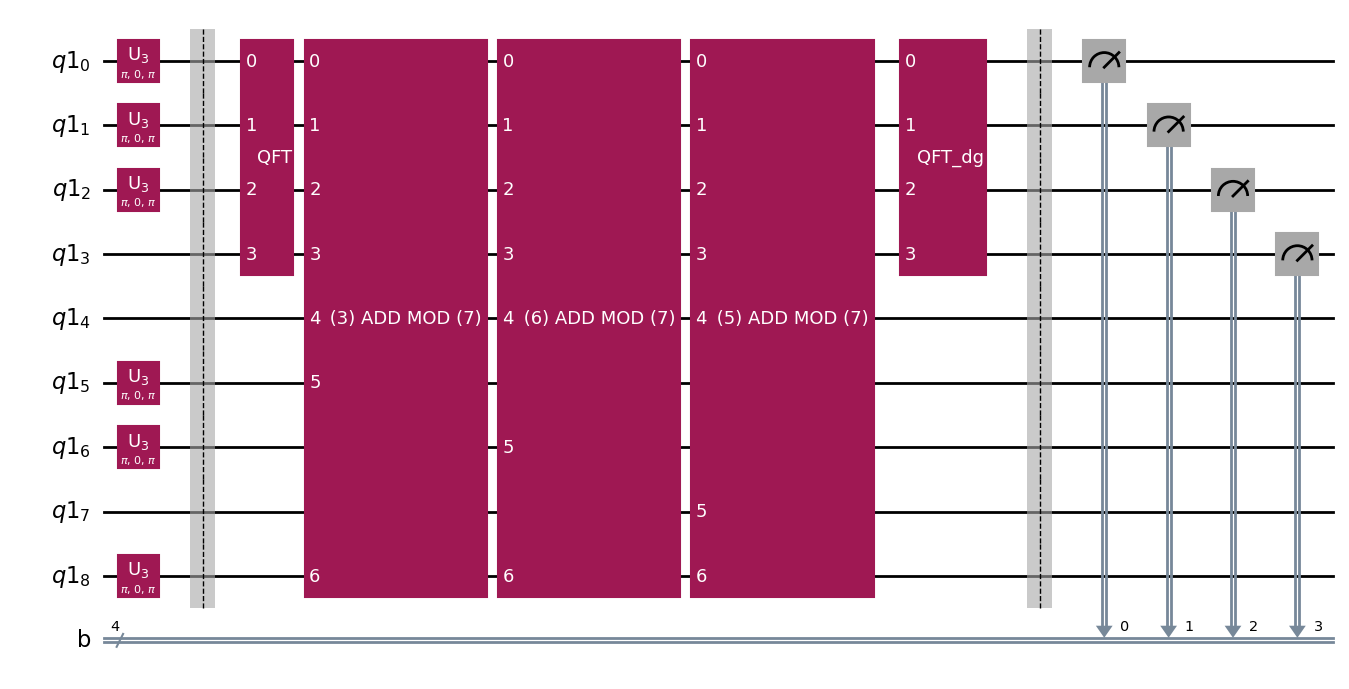

In [17]:
# --- Simple Test Case for CMULTaMODN_c ---

b_val = 7
n = get_bits(b_val)
a_val = 3
N_val = 7
x_val = 3
x_len = get_bits(x_val-1) # -1 since we only need n+1 for b rather than x

expected_val =( b_val + a_val * x_val ) % N_val

# b[0]...b[n-1] | a[0]...a[m-1] | N[0]...N[l-1] | ctrl_aux | x[0]...x[x-1] | ctrl_1 |
# 1. Quantum + Classical Registers
num_qubits = n + x_len + 2 #(aux and ctrl_1)
qr = QuantumRegister(num_qubits)
cr = ClassicalRegister(n,'b')
qc = QuantumCircuit(qr, cr)

# 2. Initialize b
apply_value(qc, b_val, 0, n)

# 3. Initialize x 
apply_value(qc, x_val, n + 1, x_len)

# 4. Set control bits, init Ctrl_1
qc.x(qr[-1])

# 5. Expected outcome (b + a*x) mod N = (4 + 3*3) MOD (7) = 13 MOD 7 = 6 -> |0100>
qc.barrier()

# 6. Build and append the multiplier 
multiplier = CMULTaMODN_c(n=n, x = x_len).build(a_val, N_val)
qc.append(multiplier, qr[:])
qc.barrier()

# 7. Measure the result
qc.measure(qr[0:n], cr)

# 8. Draw our circuit
qc.decompose().draw('mpl')


In [18]:
# 1. Setup quantum sampler 
sampler = Sampler()
job_CMULTsMODN = sampler.run([qc],shots=4096)
result = job_CMULTsMODN.result()

# 2. Get sampling result.
print(result[0])
print(result[0].data)
print(result[0].data._data.keys())
bit_array = result[0].data['b']
counts = bit_array.get_counts()
print(counts)

if counts:
    most_likely_binary_rev = max(counts, key=counts.get)
    readable_binary = most_likely_binary_rev
    measured_val = int(readable_binary, 2)
    print("-------------- Result summary --------------")
    print(f"( {b_val} + {a_val} * {x_val} ) MOD {N_val}")
    print(f"Expected value:{expected_val}")
    print(f"(Most likely) measured value: {measured_val} (binary: {readable_binary}), with shot {counts}")

SamplerPubResult(data=DataBin(b=BitArray(<shape=(), num_shots=4096, num_bits=4>)), metadata={'shots': 4096, 'circuit_metadata': {}})
DataBin(b=BitArray(<shape=(), num_shots=4096, num_bits=4>))
dict_keys(['b'])
{'0010': 4096}
-------------- Result summary --------------
( 7 + 3 * 3 ) MOD 7
Expected value:2
(Most likely) measured value: 2 (binary: 0010), with shot {'0010': 4096}


Incrediable! you've just built and successfully tested the `CMULT(a)MOD(N)` gate!

## Controlled-$U_{a}$ Gate (Modular Exponentiation)

How can we compute the sequence of controlled-$U^{2^{j}}$ operations used by the phase estimation procedure? We wish to compute the transformation

$$
\begin{array}{rl}
|z\rangle|y\rangle& \mapsto |z\rangle U^{z_{t}2^{t-1}}...U^{z_{1}2^{0}}|y\rangle \\
\ & = |z\rangle |x^{z_{t}2^{t-1}} \times \cdots \times x^{z_{1}2^{0}} y \text{mod} \ N\rangle \\
\ & = |z\rangle |x^{z}y(\text{mod}\ N)\rangle \\
\end{array}
$$

Thus the sequence of controlled-$U^{2^{j}}$ operations used in phase estimation is equivalent to multiplying the contents of the second register by the *modular exponentiation* $x^{z}(\text{mod}N)$, where $z$ is the contents of the first register.

This algorithm for computing the modular exponential has two stages.

1.  Compute the powers $x^{2} \bmod N,\ x^{4} \bmod N,\ \ldots,\ x^{2^{j}} \bmod N$ for all $j$ up to $t - 1$.  
    In theory, as suggested in *Nielsen and I. L. Chuang*, we should use:

    $$
    t = 2L + 1 + \left\lceil \log\left(2 + \frac{1}{2\epsilon}\right) \right\rceil = O(L)
    $$
    
    where $L = \lceil \log_2 N \rceil$ and $\epsilon$ is the desired precision, for example 0.95 means expectation value. However, in our implementation, we choose $t$ as the **minimum number of bits needed to represent the classical number**, plus **one extra bit** to handle potential overflow.

This results in $t - 1 = O(L)$ squaring operations, each costing $O(L^2)$, for a total classical preprocessing cost of $O(L^3)$ in this stage.

2. The second stage builds on the key observation:

    $$
    x^z \bmod N = \left( x^{z_t 2^{t-1}} \bmod N \right) \cdot \left( x^{z_{t-1} 2^{t-2}} \bmod N \right) \cdots \left( x^{z_1 2^0} \bmod N \right)
    $$

    Each term is a modular multiplication conditioned on the bits of $z$, and we perform $t - 1$ of them. Each multiplication costs $O(L^2)$, leading to a total quantum gate cost of $O(L^2)$.

> If we follow the *Nielsen and I. L. Chuang* method and choose $t = O(L)$ to guarantee sufficient precision in the phase estimation step (e.g., $t = 2L + 1 + \lceil \log(2 + 1/(2\epsilon)) \rceil$), this results in a total of $O(L^2)$ controlled modular multiplications — keeping the full modular exponentiation circuit efficient and scalable.

---

The final component of the quantum routine in Shor’s algorithm is the **controlled modular exponentiation** gate, $C\text{-}U_a$, which performs:

$$
|x\rangle|0\rangle \rightarrow |x\rangle|(a^x \bmod N)\rangle
$$

This is constructed using the `CMULT(a)MOD(N)` gate as follows:

- We first apply the `CMULT(a)MOD(N)` gate to the input $|c\rangle|x\rangle|0\rangle$.
- Then, we conditionally SWAP the result register with $|x\rangle$ if $|c\rangle = 1$.
- Finally, we apply the inverse circuit `CMULT(a^{-1})MOD(N)` to uncompute any garbage and return the ancilla to $|0\rangle$.

### Properties

- If $|c\rangle = 0$, the operation is the identity.
- If $|c\rangle = 1$, the net effect is:
  
  $$
  |x\rangle|0\rangle \rightarrow |(a^x \bmod N)\rangle
  $$
  
  since the ancilla ends in $|0\rangle$ again after uncomputation.

### Efficiency & Classical Help

- The inverse $a^{-1} \bmod N$ is computed classically using the extended Euclidean algorithm since $\gcd(a, N) = 1$.
- We can precompute $a^{2^j} \bmod N$ classically for each exponent bit, and implement powers of $C\text{-}U_a$ directly.

This gate is essential for performing **modular exponentiation** under control, which is the core operation needed for the **quantum period-finding** subroutine in Shor’s algorithm.


In [19]:
class Controlled_U_a:
    def __init__(self, n, x, c1 = 1, ctrl_aux = 1, check_flag=False):
        """Initialize the stress test with parameters a, b, and N."""
        self.n = n # number of bits for b
        self.c1 = c1  # number of bits for c1
        self.x = x  # number of bits for x
        self.ctrl_aux = ctrl_aux  # index for aux control bit
        self.check_flag = check_flag  # Flag to check aux control bit #TODO

    def build(self, a_val, N_val):
        # b[0]...b[n-1] | a[0]...a[m-1] | N[0]...N[l-1] | ctrl_aux | x[0]...x[x-1] | ctrl_1 |
        num_qubits = self.n + self.x + self.c1 + self.ctrl_aux  # +1 for ctrl_aux
        qc = QuantumCircuit(num_qubits, name=f"CTRL_U_({a_val}) MOD {N_val}")
        
        idx = 0
        qr_b = list(qc.qubits[idx : idx + self.n])
        idx += self.n

        # aux
        qr_ctrl_aux = list(qc.qubits[idx : idx + self.ctrl_aux])
        idx += self.ctrl_aux
        
        # ctrl_2 = x
        qr_x = list(qc.qubits[idx : idx + self.x]) # ctrl_2 # check x length
        idx += self.x
        
        qr_ctrl_1 = list(qc.qubits[idx : idx + self.c1])
        
        """Build the Controlled-U_a gate."""
        # 1) a·x mod N controlled on qr_aux→qr_b register
        mult_gate = CMULTaMODN_c(n=self.n, x=self.x).build(a_val, N_val)
        qc.append(mult_gate, qr_b + qr_ctrl_aux + qr_x + qr_ctrl_1)

        # 2) swap x <-> b under qr_ctrl_1[0]
        ctrl = qr_ctrl_1[0]
        for i in range(self.x): 
            qc.cswap(ctrl, qr_x[i], qr_b[i])

        # 3) inverse multiply to uncompute b
        a_inv = pow(a_val, -1,N_val)
        inv_gate = CMULTaMODN_c(n=self.n, x=self.x).build_inverse(a_inv, N_val)
        qc.append(inv_gate, qr_b + qr_ctrl_aux + qr_x + qr_ctrl_1)
        
        return qc.to_gate()
    
    def build_inverse(self, a_val, N_val):
        """Builds the inverse gate to subtract the classical value a_val."""
        CTRL_U_a_gate = self.build(a_val, N_val)
        return CTRL_U_a_gate.inverse()

In [20]:
## test code
## Controlled_U_a

a_val = 3
N_val = 4
x_val = 3
x_len = get_bits(x_val-1)  # what out the x length for generalization

b_val = 0
n = x_len + 1
print(n)

expected_val =( b_val + a_val * x_val ) % N_val

# b[0]...b[n-1] | a[0]...a[m-1] | N[0]...N[l-1] | ctrl_aux | x[0]...x[x-1] | ctrl_1 |

# Quantum + Classical Registers
num_qubits = n + x_len + 2 #(aux and ctrl_1)
qr = QuantumRegister(num_qubits)
cr = ClassicalRegister(x_len,'x')
qc = QuantumCircuit(qr, cr)

# Initialize b
apply_value(qc, b_val, 0, n)

# Initialize x 
apply_value(qc, x_val, n + 1, x_len)

# Set control bits
# init Ctrl_1
qc.x(qr[-1])

# Expected outcome (b + a*x) mod N = (4 + 3*3) MOD (7) = 13 MOD 7 = 6 -> |0100>
qc.barrier()



4


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=9, num_clbits=0, params=[]), qubits=(<Qubit register=(9, "q2"), index=0>, <Qubit register=(9, "q2"), index=1>, <Qubit register=(9, "q2"), index=2>, <Qubit register=(9, "q2"), index=3>, <Qubit register=(9, "q2"), index=4>, <Qubit register=(9, "q2"), index=5>, <Qubit register=(9, "q2"), index=6>, <Qubit register=(9, "q2"), index=7>, <Qubit register=(9, "q2"), index=8>), clbits=())

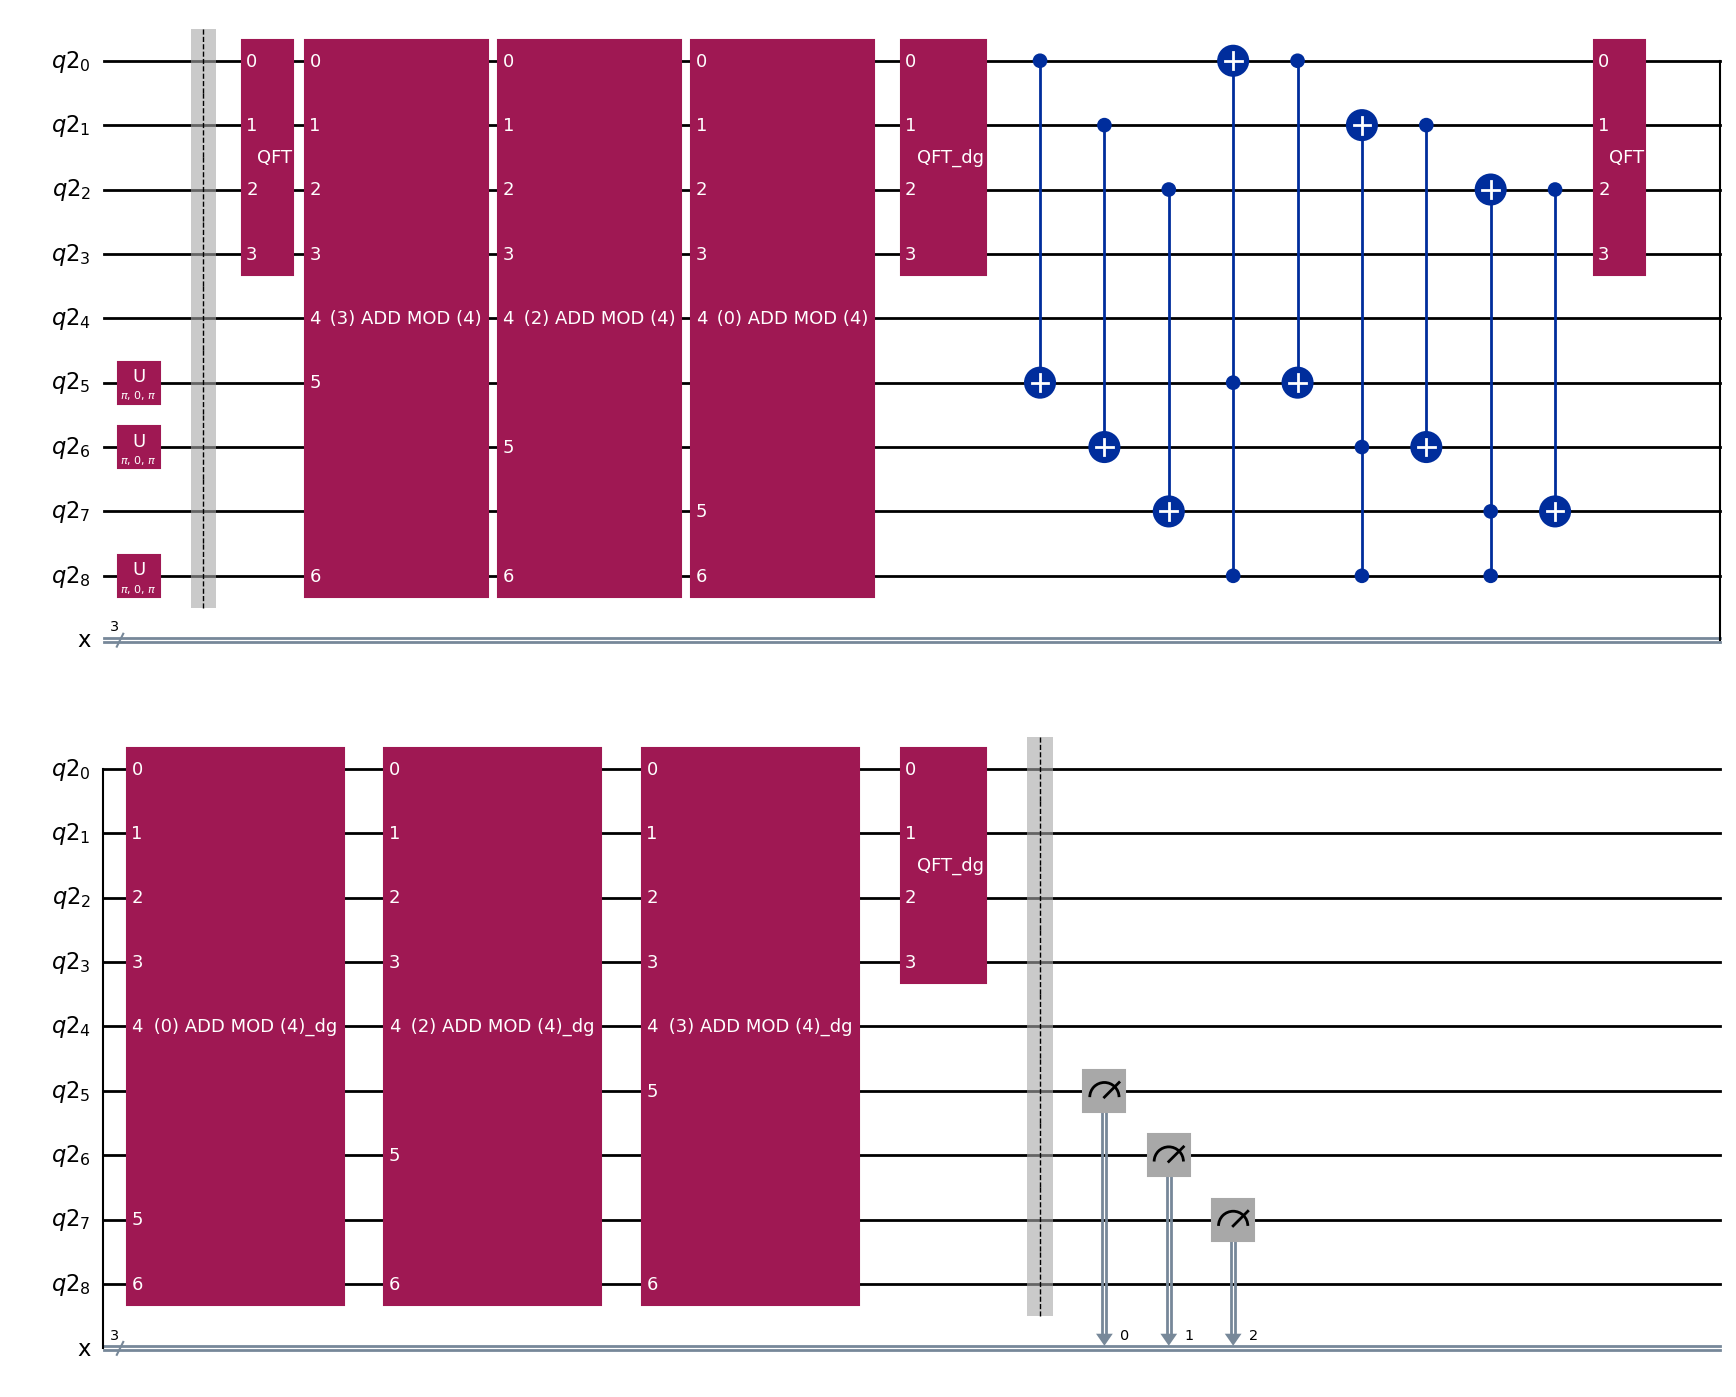

In [21]:
# Build and append the multiplier 
multiplier = Controlled_U_a(n=n, x = x_len).build(a_val, N_val)
qc.append(multiplier, qr[:])
qc.barrier()

# Measure the result @ x
qc.measure(qr[n+ 1 : n + x_len+1], cr)

qc.decompose().decompose().draw('mpl')
#qc.draw('mpl')

In [22]:
sampler = Sampler()
job_CTRL_U_a = sampler.run([qc],shots=4096)
result = job_CTRL_U_a.result()

print(result[0])

print(result[0].data)
print(result[0].data._data.keys())

bit_array = result[0].data['x']
counts = bit_array.get_counts()
print(counts)

if counts:
    #Qiskit returns binary strings in reverse order, so we flip it
    most_likely_binary_rev = max(counts, key=counts.get)
    readable_binary = most_likely_binary_rev
    measured_val = int(readable_binary, 2)
    print("-------------- Result summary --------------")
    print(f"( {b_val} + {a_val} * {x_val} ) MOD {N_val}")
    print(f"Expected value:{expected_val}")
    print(f"(Most likely) measured value: {measured_val} (binary: {readable_binary}), with shot {counts}")

SamplerPubResult(data=DataBin(x=BitArray(<shape=(), num_shots=4096, num_bits=3>)), metadata={'shots': 4096, 'circuit_metadata': {}})
DataBin(x=BitArray(<shape=(), num_shots=4096, num_bits=3>))
dict_keys(['x'])
{'001': 4096}
-------------- Result summary --------------
( 0 + 3 * 3 ) MOD 4
Expected value:1
(Most likely) measured value: 1 (binary: 001), with shot {'001': 4096}


Oh my god... you made it! 🎉 You’ve just implemented the **Controlled-$U_{a}$ gate** — a.k.a. the **modular exponentiation** gate — which is hands down one of the most difficult and expensive parts of Shor’s algorithm!

This gate is the core of quantum period finding, and now that you’ve built it from scratch, you’re ready to put everything together.

Let’s run our handmade version of **Shor’s algorithm** using the following code block!

---

### Euler's Totient Theorem (Optional)

In Qiskit, quantum circuits only support integer-based unitary operations — meaning you can't perform division, use floating-point numbers, or write expressions like $1/a$ directly in a quantum gate. This becomes especially important when building arithmetic circuits like the Controlled-$U_a$, where we need to reverse a modular multiplication. To handle this, we bring in *Euler's Totient Theorem*.

1.  **The Goal:** We're trying to find an integer $a_{\text{inv}}$ such that:

   $$
   a \times a_{\text{inv}} \mod N = 1
   $$

2.  **Euler's Totient Function** ($\phi(N)$): This function counts how many numbers less than $N$ are coprime to $N$.  
   For example, $\phi(15) = 8$ because the numbers $\{1, 2, 4, 7, 8, 11, 13, 14\}$ don’t share any factors with 15.

3.  **Euler's Totient Theorem:** If $a$ and $N$ are coprime (which is required for an inverse to exist), then:

   $$
   a^{\phi(N)} \equiv 1 \mod N
   $$

   In other words, raising $a$ to the power $\phi(N)$ gives 1 modulo $N$.

Now, with a little algebra, we can connect this to modular inverses:

-   We know: $a^{\phi(N)} \equiv 1 \mod N$
-   Rewrite it: $a \times a^{\phi(N) - 1} \equiv 1 \mod N$

Compare that to the definition of an inverse:

-   $a \times a^{\phi(N) - 1} \equiv 1 \mod N$
-   $a \times a_{\text{inv}} \equiv 1 \mod N$

So we get:

$$
a_{\text{inv}} = a^{\phi(N) - 1} \mod N
$$

That’s the mathematical definition of the modular inverse — raising $a$ to $\phi(N) - 1$.

But here’s the thing: when you call `pow(a, -1, N)` in Python, it **doesn't** calculate $a^{\phi(N)-1} \mod N$. That would be way too slow, since you'd need to compute $\phi(N)$ first. Instead, Python recognizes the `-1` as a request for the modular inverse and uses a much faster method: the **Extended Euclidean Algorithm**. It’s the standard go-to algorithm for computing the inverse directly — no need to touch $\phi(N)$ at all.

#### When the Inverse Doesn't Exist

The modular inverse of $a \mod N$ only exists if $a$ and $N$ are **coprime** — meaning their greatest common divisor is 1.

In **Shor's algorithm**, this isn't a bug — it's actually a feature. When you randomly pick an $a$, the very first thing you should do is compute `gcd(a, N)`:

1. If `gcd(a, N) != 1`, then you’ve already found a **non-trivial factor** of $N$ by pure luck — and you can stop the algorithm right there.
2. If `gcd(a, N) = 1`, then a modular inverse **is guaranteed to exist**, and you can safely proceed with building the $U_a$ gate.

Also note: Python’s `pow(a, -1, N)` will raise a `ValueError` if the inverse does not exist. So your code should be prepared to catch this and handle it appropriately — it may just mean you got lucky and factored $N$ early!

---

## Constructing a Period-Finding / Phase Estimation Circuit

<div style="text-align: center;">
    <img src="../../images/QPE_overview_0.png" alt="QPE_overview_0" style="width: 765px; height: 352px;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        The order-finding circuit for quantum factorization from Beauregard.
    </p>
</div>

>💡 In this notebook, we set `t = n` for faster results, instead of the recommended `t = 2n` as suggested in the original paper. Luckily, since 15 is a simple case, this shortcut still gives us pretty good results!

🎯 Finally, our last step is to put everything together — the QFT, modular arithmetic, and controlled-$U_a$ — to build and run the phase estimation circuit that powers Shor’s algorithm!

The quantum part of Shor’s algorithm is entirely focused on solving one key problem:  
finding the order of a randomly chosen number $a$ modulo $N$, where $N$ is the $n$-bit integer we want to factor.

The **order** $r$ of $a \mod N$ is the smallest positive integer such that:

$$
a^{r} \equiv 1 \mod N
$$

This is a classic period-finding problem, and it's where quantum computing provides exponential speedup using phase estimation.




Initializing registers...
Building and applying Controlled-Ua gates...
Applying Inverse QFT...
Drawing circuit diagram...


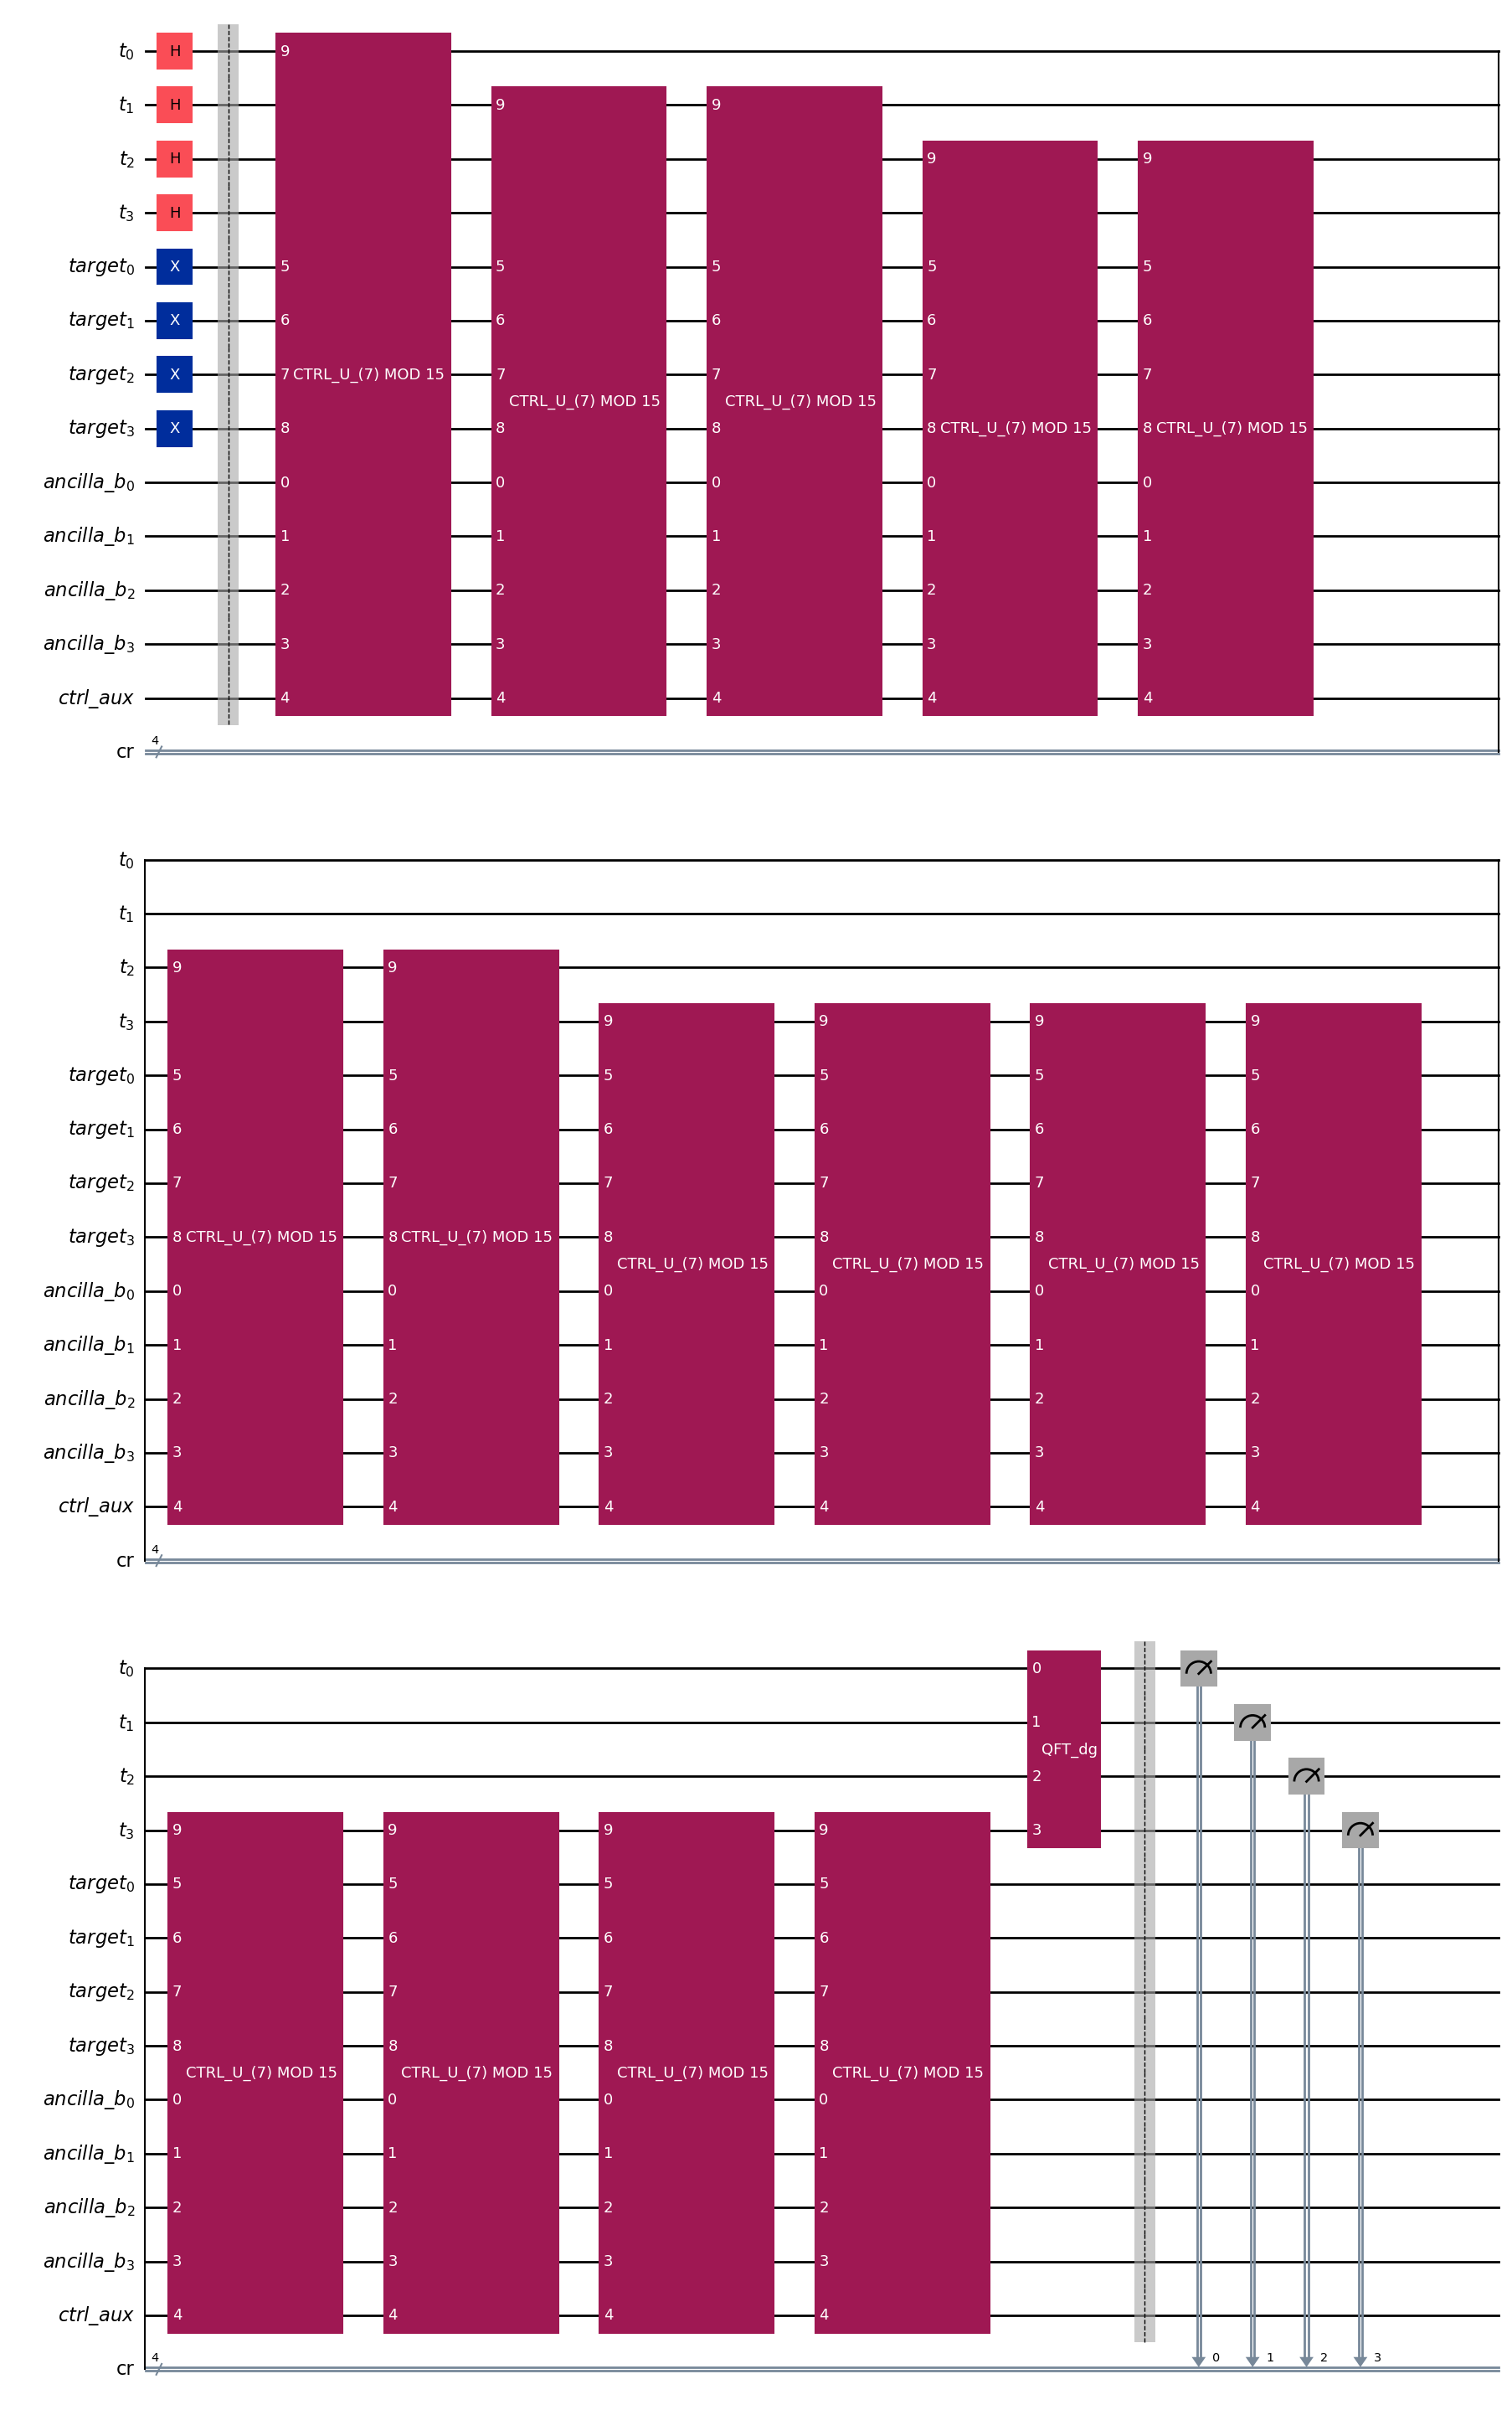

In [23]:
# circuit layout
# b[0]...b[n-1] | a[0]...a[m-1] | N[0]...N[l-1] | ctrl_aux | x[0]...x[x-1] | ctrl_1 |

# --- Parameters ---
a_val = 7 
N_val = 15
n = get_bits(N_val)-1 # should be 4 for 15
t = 1*n # For demonstration

#   1. Create the Parent Circuit ---
counting_register = QuantumRegister(t, name='t') # ctrl_ 1 
target_register = QuantumRegister(n, name='target') # Target, U gate, init to |1>
ancilla_b_reg = QuantumRegister(n, name='ancilla_b')
ctrl_aux_reg = QuantumRegister(1, name='ctrl_aux')

cr = ClassicalRegister(t,'cr')
qc = QuantumCircuit(counting_register, target_register, ancilla_b_reg, ctrl_aux_reg, cr)

#   2. Initialize the Registers ---
print("Initializing registers...")
qc.h(counting_register) # Put counting register in superposition
qc.x(target_register) # Initialize target register to |1>
qc.barrier()

#   3. The Core Loop: This is there t = 8 is used ---
print("Building and applying Controlled-Ua gates...")

Ctrl_U_a_gate = Controlled_U_a(n=n, x=n).build(a_val=a_val, N_val=N_val)

for i in range(t): 
    U_a_power = 2**i
    for j in range(U_a_power):
        # b[0]...b[n-1] | a[0]...a[m-1] | ctrl_aux | x[0]...x[x-1] | ctrl_1 |
        qubit_list = ancilla_b_reg[:] + ctrl_aux_reg[:]  + target_register[:] + [counting_register[i]]
        qc.append(Ctrl_U_a_gate, qubit_list)

# Apply inverse QFT
print("Applying Inverse QFT...")
iqft = QFTBlock(t+2*n+1)
qc.append(iqft_gate, counting_register)
qc.barrier()

# Measure t register
qc.measure(counting_register, cr)

# Print our circuit.
print("Drawing circuit diagram...")
qc.draw('mpl')

In [24]:
sampler = Sampler()
job_PE_MOD_15 = sampler.run([qc],shots=4096*2)
result = job_PE_MOD_15.result()

print(result[0])
print(result[0].data)
print(result[0].data._data.keys())

bit_array = result[0].data['cr']
counts = bit_array.get_counts()
print(counts)

#TODO: add historgram plot


SamplerPubResult(data=DataBin(cr=BitArray(<shape=(), num_shots=8192, num_bits=4>)), metadata={'shots': 8192, 'circuit_metadata': {}})
DataBin(cr=BitArray(<shape=(), num_shots=8192, num_bits=4>))
dict_keys(['cr'])
{'1010': 495, '1101': 526, '1001': 526, '0100': 515, '1011': 510, '1000': 485, '0101': 485, '0111': 524, '0011': 535, '1100': 526, '0010': 550, '0000': 506, '0110': 484, '1110': 520, '1111': 501, '0001': 504}


In [25]:
from fractions import Fraction
# Get the most frequent measurement
measured_string = max(counts, key=counts.get)
y = int(measured_string, 2)
print(f"Most frequent measurement: |{measured_string}> (y = {y})")

## 5. Classical Post-Processing
print("\nStarting classical post-processing...")
phase = y / (2**t)
print(f"Phase (φ) = y / 2^t = {y}/{2**t} = {phase}")

# Use Continued Fractions to find the period r
frac = Fraction(phase).limit_denominator(N_val)
s, r = frac.numerator, frac.denominator
print(f"Continued fractions result: s/r = {s}/{r}")

if r % 2 != 0:
        print(f"Period r={r} is odd. Algorithm fails. Please try another 'a'.")
else:
    x = pow(a_val, r // 2, N_val)
    if (x + 1) % N_val == 0:
        print(f"x+1 is a multiple of N. Algorithm fails. Please try another 'a'.")
    else:
        factor1 = math.gcd(x - 1, N_val)
        factor2 = math.gcd(x + 1, N_val)
        print("\n" + "="*20)
        print(f"SUCCESS: Factors are {factor1} and {factor2}")
        print("="*20)

Most frequent measurement: |0010> (y = 2)

Starting classical post-processing...
Phase (φ) = y / 2^t = 2/16 = 0.125
Continued fractions result: s/r = 1/8

SUCCESS: Factors are 15 and 1


⚠️ You may not directly obtain 3 and 5 as the result due to the limited precision we chose. To improve accuracy, you can either use `t = 2n` or follow the textbook method:

$$
t = 2L + 1 + \left\lceil \log\left(2 + \frac{1}{2\epsilon}\right) \right\rceil = O(L)
$$

Fortunately, I’ve implemented a loop that keeps trying until we avoid trivial or odd values of $r$, so eventually we’ll recover the correct factors — **3 and 5** — using the `gcd` result!

In [26]:
# A loop that finds the non-trival solution 


def sampling():
    print("Sampling...")
    sampler = Sampler()
    job = sampler.run([qc], shots=8192)
    result = job.result()
    counts = result[0].data['cr'].get_counts()
    return counts

def post_processing(counts):
    measured_string = max(counts, key=counts.get)
    y = int(measured_string, 2)
    print(f"Most frequent measurement: |{measured_string}> (y = {y})")

    phase = y / (2**t)
    print(f"Phase (φ) = y / 2^t = {y}/{2**t} = {phase}")

    frac = Fraction(phase).limit_denominator(N_val)
    s, r = frac.numerator, frac.denominator
    print(f"Continued fractions result: s/r = {s}/{r}")
    return r

Non_trivial = False
while not Non_trivial:
    counts = sampling()
    r = post_processing(counts)

    if r % 2 != 0:
        print("case1: r is odd")
        continue

    x = pow(a_val, r // 2, N_val)
    if (x + 1) % N_val == 0:
        print("case2: x + 1 ≡ 0 mod N")
        continue

    factor1 = math.gcd(x - 1, N_val)
    factor2 = math.gcd(x + 1, N_val)
    if factor1 == 1 or factor2 == 1:
        print("case3: one factor is trivial (1)")
        continue

    print("\n" + "=" * 20)
    print(f"SUCCESS: Factors are {factor1} and {factor2}")
    print("=" * 20)
    Non_trivial = True

            

Sampling...
Most frequent measurement: |0011> (y = 3)
Phase (φ) = y / 2^t = 3/16 = 0.1875
Continued fractions result: s/r = 2/11
case1: r is odd
Sampling...
Most frequent measurement: |1111> (y = 15)
Phase (φ) = y / 2^t = 15/16 = 0.9375
Continued fractions result: s/r = 14/15
case1: r is odd
Sampling...
Most frequent measurement: |0101> (y = 5)
Phase (φ) = y / 2^t = 5/16 = 0.3125
Continued fractions result: s/r = 4/13
case1: r is odd
Sampling...
Most frequent measurement: |1100> (y = 12)
Phase (φ) = y / 2^t = 12/16 = 0.75
Continued fractions result: s/r = 3/4

SUCCESS: Factors are 3 and 5


🎉 Congratulations! You’ve just completed one of the most exciting topics in quantum computing: **Shor’s algorithm**, built entirely from scratch using basic quantum gates. This is a major step toward understanding how quantum computers can solve problems that classical methods simply can’t. You’ve just unleashed quantum power where classical algorithms fall short!